沪深300股票指数由中证指数公司编制的沪深300指数于2005年4月8日正式发布。沪深300指数以2004年12月31日为基日，基日点位1000点·沪深300指数是由上海和深圳证券市场中选取300只A股作为样本，其中沪市有179只，深市121只样本选择标准为规模大，流动性好的股票。沪深300指数样本覆盖了沪深市场六成左右的市值，具有良好的市场代表性。作为一种商品。

tushare包的get_k_data()函数来获取股票交易数据

In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
#正常显示画图时出现的中文
import matplotlib as mpl
#使用微软雅黑字体
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
import seaborn as sns  
import tushare as ts
%matplotlib inline    

In [4]:
# 沪深300:hs300
data=ts.get_k_data(code='hs300',ktype='D',
  autype='qfq', start='2005-04-08') 
#code:股票代码，个股主要使用代码，如‘600000’
#ktype:'D':日数据；‘m’：月数据，‘Y’:年数据
#autype:复权选择，默认‘qfq’前复权
#start：起始时间
#end：默认当前时间
data.head(5)

,date,open,close,high,low,volume,code
0,2005-04-08,984.66,1003.45,1003.70,979.53,14762500.0,hs300
1,2005-04-11,1003.88,995.42,1008.73,992.77,15936100.0,hs300
2,2005-04-12,993.71,978.70,993.71,978.20,10226200.0,hs300
3,2005-04-13,987.95,1000.90,1006.50,987.95,16071700.0,hs300
4,2005-04-14,1004.64,986.97,1006.42,985.58,12945700.0,hs300


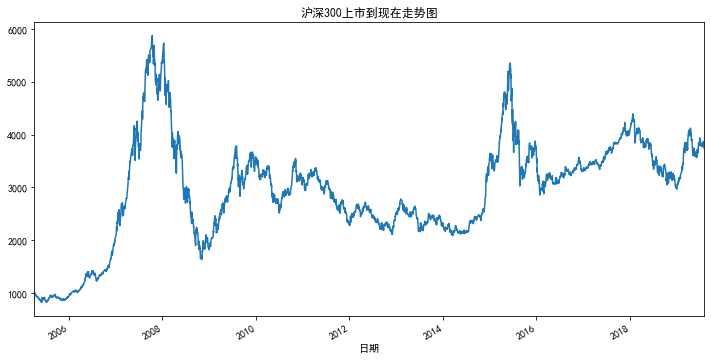

In [7]:
# 将date设置索引
data.index = pd.to_datetime(data['date'])
#画出沪深300收盘价的走势
data['close'].plot(figsize=(12,6))
plt.title('沪深300上市到现在走势图')
plt.xlabel('日期')
plt.show()

In [6]:
data.describe()

,open,close,high,low,volume
count,3484.000000,3484.000000,3484.000000,3484.000000,3.484000e+03
mean,2928.273123,2931.296405,2958.403556,2898.029648,8.977392e+07
std,987.092467,986.804852,997.793593,972.885668,8.236453e+07
min,816.550000,818.030000,823.860000,807.780000,5.962460e+06
25%,2338.005000,2341.525000,2366.672500,2321.192500,4.349212e+07
50%,3056.855000,3061.262000,3087.105000,3028.150000,7.041817e+07
75%,3520.145000,3521.555000,3550.977500,3485.400000,1.024139e+08
max,5862.380000,5877.200000,5891.720000,5815.610000,6.864391e+08


从上述结果可以看出，沪深300从2005年4月8日至现在（最后交易日是当前运行时间），一共有3484个样本，均值为2928点，标准差为987（波动还是比较大的），最大值是5862点。

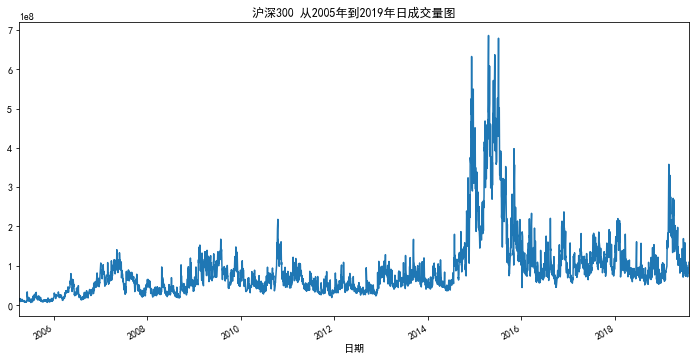

In [9]:
#再查看下每日成交量 
#2006年市场容量小，交易量比较小，我们从2007年开始看
data.loc["2005-4-08":]["volume"].plot(figsize=(12,6))
plt.title('沪深300 从2005年到2019年日成交量图')
plt.xlabel('日期')
plt.show()

上图的成交量反映了一个2007到2008年的大牛市人类可能不怎么认识股票，如此火爆竟然没人买，是我就马上下注了，可以少奋斗人生，2015到2016也涨得不错，果然是购买的人暴了。感兴趣的朋友可以结合货币供给、实体经济指标、等数据一起分析。

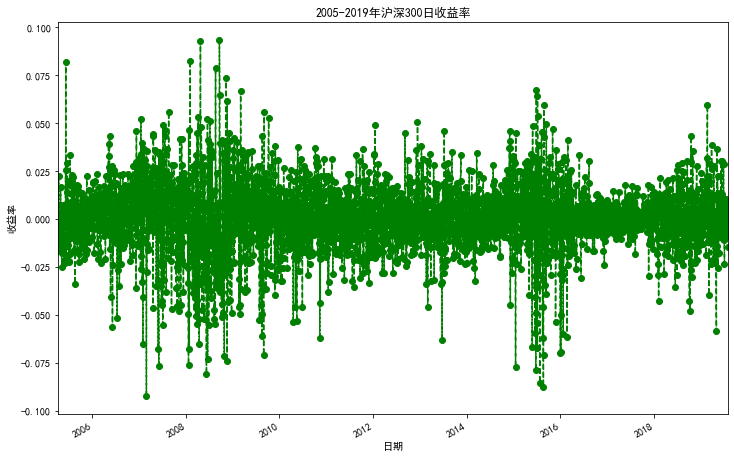

In [14]:
#沪深300日收益率
# pct_change() 等价于 (data["close"] / data["close"].shift(1)) - 1
data["日收益率"] = data["close"].pct_change()
data["日收益率"].loc['2005-4-8':].plot(figsize=(12,8),linestyle="--",marker="o",color="g")
plt.xlabel('日期')
plt.ylabel('收益率')
plt.title('2005-2019年沪深300日收益率')
plt.show()

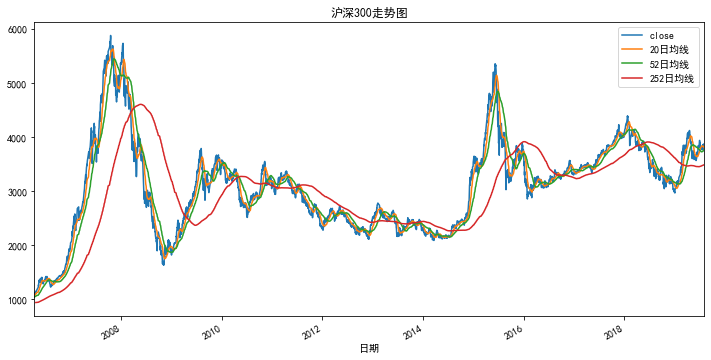

In [29]:
#这里的平均线是通过自定义函数，手动设置20,52,252日均线
#移动平均线：
ma_day = [20,52,252] # 月，季，年
# 因为银行一年周末不上班，使用一年就上班大约253天
for ma in ma_day:
    column_name = "%s日均线" %(str(ma))
    # 如果不存在就nan
    data[column_name] = data["close"].rolling(ma).mean()
#画出2006年以来收盘价和均线图
data.loc['2006-4-8':][["close","20日均线","52日均线","252日均线"]].plot(figsize=(12,6))
plt.title('沪深300走势图')
plt.xlabel('日期')
plt.show()

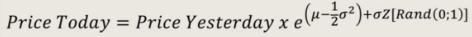

In [46]:
from scipy.stats import norm
# 蒙特卡洛模拟股票
# 对数收益率
log_returns = np.log(1 + data["close"].pct_change())
# 对数收益率平均值
u = log_returns.mean()
# 对数收益率方差
var = log_returns.var()
# 布朗运动的漂移（过去的收益率）
drift = u - (0.5 * var)
# 对数收益率标准差
stdev = log_returns.std()
# 一年交易252(预测一年）
t_intervals = 252
# 迭代10次 
iterations = 10
# 重点 每天的回报 历史的收益率
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns.shape # (252, 10)

(252, 10)

In [48]:
# 将最后一天作为开始
S0 = data["close"].iloc[-1]
# 创建（252，10）的零矩阵
price_list = np.zeros_like(daily_returns)
# 将S0 赋予 price_list[0]
price_list[0] = S0

In [49]:
#在范围（1，t_间隔）内创建一个循环，该循环将日价格（t-1）与日回报值（t）的乘积重新分配给时间t中的价格。
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

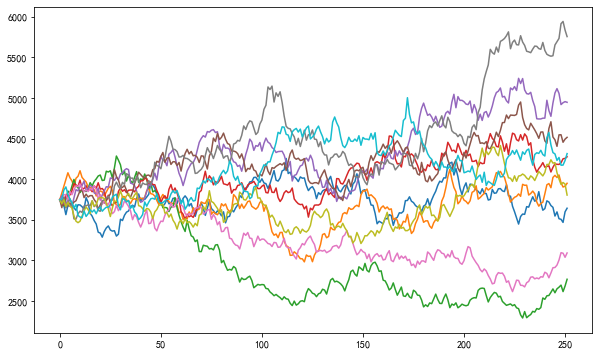

In [51]:
plt.figure(figsize=(10,6))
plt.plot(price_list)
plt.show()

可见对于股票传统的蒙特卡洛的无法准确的预测，所以必须使用更加高级的深度学习模型来学习，预测股票未来的发展走势